In [21]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math
import time

In [22]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        #print(k_fold_size)
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [23]:
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

In [24]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data = pd.read_csv('Data_final.csv', index_col = 0)
#data = gpd.read_file('Data_full_mandals.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [25]:
data['ModifiedDateTime'] = pd.to_datetime(data['ModifiedDateTime'])

In [26]:
warnings.filterwarnings('ignore')

In [27]:
del data['geometry']
data = pd.merge(data, mandal_boundaries[['index', 'geometry']], how='left', on=['index'])

Data Split

In [28]:
train = data[data['ModifiedDateTime']<'2018']
test = data[data['ModifiedDateTime']>='2018']
print(len(train), len(test))

train = train.reset_index()
test = test.reset_index()

del train['level_0']
del test['level_0']

4284 2162


In [29]:
data.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'ModifiedDateTime', 'Year', 'Month',
       'Season', 'NO2', 'PM2.5', 'SSM_mean', 'SSM_median', 'SSM_min',
       'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median', 'PRE_min',
       'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'POP_mean', 'POP_median',
       'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90',
       'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90',
       'BA_mean', 'BA_median', 'BA_sum', 'Area_Crops', 'Area_Trees',
       'Area_Built_Area', 'time_to_rur_median', 'PowP_score', 'Soil Type',
       'CropA_Paddy', 'CropA_Maize', 'CropA_Soybean', 'CropA_Cotton',
       'CropA_Chillies', 'CropA_Turmeric', 'SoilT_Chromic_Luvisols',
       'SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols',
       'SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols',
       'SoilT_Vertic_Cambisols', 'geometry'],
      dtype='object')

Predictors

In [12]:
predictors = ['NO2', 'PM2.5']

Features

In [13]:
feature_list =  ['SSM_mean', 'SSM_median', 'SSM_min',
       'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median', 'PRE_min',
       'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'POP_mean', 'POP_median',
       'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90',
       'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90',
       'BA_mean', 'BA_median', 'BA_sum', 'Area_Crops', 'Area_Trees',
       'Area_Built_Area', 'time_to_rur_median', 'PowP_score', 'Soil Type',
       'CropA_Paddy', 'CropA_Maize', 'CropA_Soybean', 'CropA_Cotton',
       'CropA_Chillies', 'CropA_Turmeric', 'SoilT_Chromic_Luvisols',
       'SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols',
       'SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols',
       'SoilT_Vertic_Cambisols']


In [14]:
feature_list_comb = [['SoilT_Chromic_Luvisols','SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols','SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols', 'SoilT_Vertic_Cambisols'],
                     ['Area_Built_Area', 'POP_mean', 'POP_median', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90', 'time_to_rur_median'],
                     ['SSM_mean', 'SSM_median', 'SSM_min','SSM_max', 'SSM_percentile_90', 'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90'],
                     ['PRE_mean', 'PRE_median', 'PRE_min','PRE_max', 'PRE_percentile_90', 'PRE_sum'],
                     ['BA_mean', 'BA_median', 'BA_sum'],
                     ['CropA_Paddy', 'CropA_Maize', 'CropA_Soybean', 'CropA_Cotton', 'CropA_Chillies', 'CropA_Turmeric', 'Area_Crops', 'Area_Trees'],
                     ['PowP_score']]

# Parameter Tuning

In [15]:
def RandomSearch(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, k_fold, btscv, train_data, predictor, feature_list, n_iters):

    X = train_data[feature_list]
    Y = train_data[predictor]

    rf = RandomForestRegressor()

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = n_iters, cv = btscv, verbose=0, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X,Y)

    return(rf_random.best_params_)


In [16]:
def GridSearch(parameters_tuned, max_depth_adds, min_samples_leaf_adds, min_samples_split_adds, n_estimators_adds, btscv, train_data, predictor, feature_list):

    features = [i for i in feature_list]    
    X = train_data[features]
    Y = train_data[predictor]

    min_max_depth = parameters_tuned['max_depth'] - max_depth_adds
    min_n_esimators = parameters_tuned['min_samples_leaf'] - min_samples_leaf_adds
    min_min_samples_split = parameters_tuned['min_samples_split'] - min_samples_split_adds
    min_min_samples_leaf = parameters_tuned['n_estimators'] - n_estimators_adds

    if min_max_depth <=0:
        min_max_depth = 1
    if min_n_esimators <=0:
        min_n_esimators = 100
    if min_min_samples_split <=0:
        min_min_samples_split = 1
    if min_min_samples_leaf <=0:
        min_min_samples_leaf = 1


    param_grid = {
    'bootstrap': [parameters_tuned['bootstrap']],
    'max_depth': [min_max_depth, parameters_tuned['max_depth'], parameters_tuned['max_depth']+ max_depth_adds ],
    'max_features': [parameters_tuned['max_features']],
    'min_samples_leaf': [min_min_samples_leaf, parameters_tuned['min_samples_leaf'],  parameters_tuned['min_samples_leaf'] + min_samples_leaf_adds],
    'min_samples_split': [min_min_samples_split , parameters_tuned['min_samples_split'], parameters_tuned['min_samples_split'] + min_samples_split_adds],
    'n_estimators': [min_n_esimators, parameters_tuned['n_estimators'], parameters_tuned['n_estimators'] + n_estimators_adds]
    }

    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = btscv, n_jobs = -1, verbose = 0)

    # Fit the grid search to the data
    grid_search.fit(X, Y)

    return grid_search.best_params_


# Feature Importances

In [17]:
def plot_feature_importances(rf_model, features_com):

    importances = list(rf_model.feature_importances_)
    feature_importances = [(feature, round(importance, 15)) for feature, importance in zip(features_com, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    names=[]
    values=[]

    for i in range(0, len(importances)):
        names.append(feature_importances[i][0])
        values.append(feature_importances[i][1])


    plt.bar(names, values)
    # Cumulative importances
    cumulative_importances = np.cumsum(importances)
    # Make a line graph
    plt.plot(names, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    #plt.hlines(y = 0.95, xmin=0, xmax=len(importances), color = 'r', linestyles = 'dashed')
    plt.xticks(names, rotation='vertical')
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
    plt.show()

    print('Feature Importances: ' + str(feature_importances))

    return(feature_importances)

# Model Selections

In [18]:
def RandomForestRegressionModel(parameters_tuned_final, features_com, predictor, btscv):

    array_X = np.array(data[features_com])
    array_Y = np.array(data[predictor])

    for train_index, test_index in btscv.split(array_X):

        MAE_folds = []
        R2_folds = []
        RMSE_folds = []
        MAPE_folds =[]
        accuracy_folds = []
        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        if parameters_tuned_final['max_features'] !='auto':
            parameters_tuned_final['max_features'] = int(len(features_com)/3)
            if parameters_tuned_final['max_features'] == 0:
                parameters_tuned_final['max_features'] = 1


        clf = RandomForestRegressor(n_estimators=parameters_tuned_final['n_estimators'], max_depth=parameters_tuned_final['max_depth'], bootstrap = parameters_tuned_final['bootstrap'], max_features = parameters_tuned_final['max_features'], min_samples_leaf = parameters_tuned_final['min_samples_leaf'], min_samples_split = parameters_tuned_final['min_samples_split'])

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        # Calculate and display accuracy
        accuracy_folds.append(100 - np.mean(mape))

        #RMSE
        MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
        RMSE_folds.append(math.sqrt(MSE_folds))

        #R2
        R2_folds.append(r2_score(y_test, predictions))

    MAE = sum(MAE_folds)/len(MAE_folds)
    RMSE = sum(RMSE_folds)/len(RMSE_folds)
    R2 = sum(R2_folds)/len(R2_folds)
    Accuracy = sum(accuracy_folds)/len(accuracy_folds)



    return(clf, MAE, RMSE, R2, Accuracy)

In [19]:
def RandomForestRegressionModelSubsets(k_fold, feature_com_list, data, train_data, predictor, n_iters):

    start_time = time.time()
    #Investigate every subset of explanatory variables
    parameter_scores = []

    for features_com in feature_com_list:
        
        print(features_com)

        btscv = BlockingTimeSeriesSplit(n_splits = k_fold)

        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        max_features = ['auto', int(len(feature_list)/3)]
        max_depth = [int(x) for x in np.linspace(6, 40, num = 10)]
        min_samples_split = [5, 10, 15, 20]
        min_samples_leaf = [2, 3, 4]
        bootstrap = [True, False]

        parameters_tuned = RandomSearch(n_estimators = n_estimators, max_features = max_features , max_depth = max_depth, min_samples_leaf = min_samples_leaf,  min_samples_split = min_samples_split, bootstrap = bootstrap, k_fold = k_fold, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com, n_iters = n_iters)

        max_depth_adds = 5
        min_samples_leaf_adds = 1
        min_samples_split_adds = 2
        n_estimators_adds = 200

        parameters_tuned_1 = GridSearch(parameters_tuned = parameters_tuned, max_depth_adds = max_depth_adds, min_samples_leaf_adds = min_samples_leaf_adds, min_samples_split_adds = min_samples_split_adds, n_estimators_adds = n_estimators_adds, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com)

        max_depth_adds = 2
        min_samples_leaf_adds = 1
        min_samples_split_adds = 1
        n_estimators_adds = 100

        parameters_tuned_final = GridSearch(parameters_tuned = parameters_tuned_1, max_depth_adds = max_depth_adds, min_samples_leaf_adds = min_samples_leaf_adds, min_samples_split_adds = min_samples_split_adds, n_estimators_adds = n_estimators_adds, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com)

        print(parameters_tuned_final)

        rf_model, MAE, RMSE, R2, Accuracy = RandomForestRegressionModel(parameters_tuned_final, features_com, predictor, btscv)

        print('MAE: ' + str(MAE))
        print('RMSE: ' + str(RMSE))
        print('R2: ' + str(R2))
        print('Accuracy: ' + str(Accuracy))

        #Feature Importances
        feature_importances = plot_feature_importances(rf_model = rf_model, features_com = features_com)

        parameter_scores.append((MAE, RMSE, R2, Accuracy, features_com, parameters_tuned_final, feature_importances))

        end_time = time.time()
        print('Time: ' + str(round((end_time-start_time)/60, 2)), ' min')

    results = pd.DataFrame(parameter_scores, columns = ['MAE', 'RMSE', 'R2', 'Accuracy', 'Features', 'Parameters', 'Feature Importances'])

    return(results)
    

NO2

['Chromic Luvisols', 'Chromic Vertisols', 'Eutric Nitosols', 'Lithosols', 'Pellic Luvisols', 'Plinthic Luvisols', 'Vertic Cambisols']
{'bootstrap': True, 'max_depth': 35, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 4}
MAE: 49.30141858295115
RMSE: 86.15774964513282
R2: -0.03039050112367714
Accuracy: 81.74155664506563


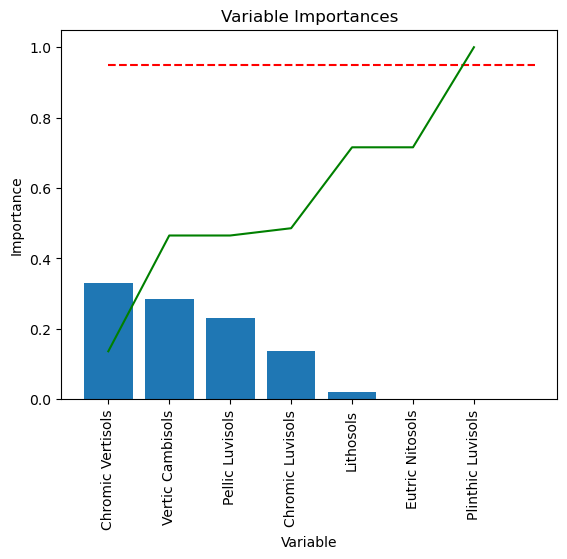

Feature Importances: [('Chromic Vertisols', 0.328929153939539), ('Vertic Cambisols', 0.284315426177505), ('Pellic Luvisols', 0.229892826906049), ('Chromic Luvisols', 0.136192304061157), ('Lithosols', 0.02067028891575), ('Eutric Nitosols', 0.0), ('Plinthic Luvisols', 0.0)]
Time: 6.2  min
['Built Area', 'POP_mean', 'POP_median', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90', 'time_to_rur_median']
{'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
MAE: 40.995207994944586
RMSE: 72.09548222771777
R2: 0.2785117638640634
Accuracy: 84.94692859903346


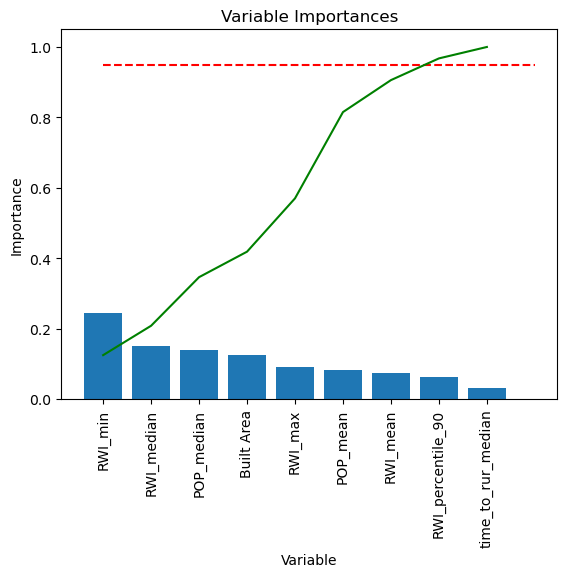

Feature Importances: [('RWI_min', 0.245101909488549), ('RWI_median', 0.151477448749673), ('POP_median', 0.138031498978468), ('Built Area', 0.124515340489519), ('RWI_max', 0.090797489880527), ('POP_mean', 0.083509950256347), ('RWI_mean', 0.072420904764322), ('RWI_percentile_90', 0.061670866046554), ('time_to_rur_median', 0.032474591346041)]
Time: 13.68  min
['SSM_mean', 'SSM_median', 'SSM_min', 'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median', 'PRE_min', 'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90']
{'bootstrap': True, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 18, 'n_estimators': 1}
MAE: 54.48451531684323
RMSE: 90.14326495761546
R2: -0.12792369495399414
Accuracy: 78.91002373222028


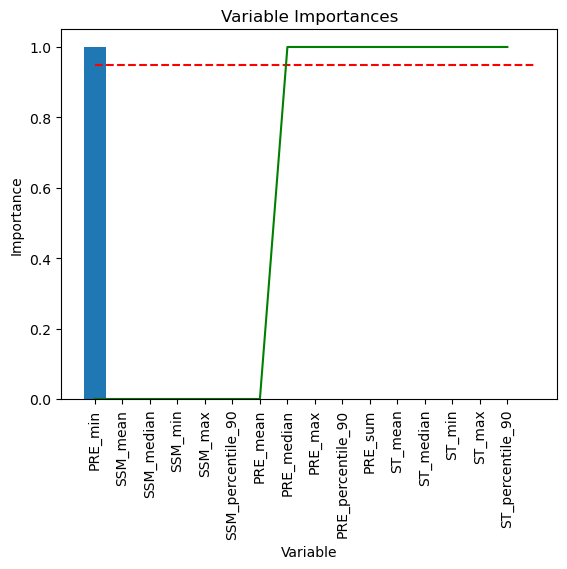

Feature Importances: [('PRE_min', 1.0), ('SSM_mean', 0.0), ('SSM_median', 0.0), ('SSM_min', 0.0), ('SSM_max', 0.0), ('SSM_percentile_90', 0.0), ('PRE_mean', 0.0), ('PRE_median', 0.0), ('PRE_max', 0.0), ('PRE_percentile_90', 0.0), ('PRE_sum', 0.0), ('ST_mean', 0.0), ('ST_median', 0.0), ('ST_min', 0.0), ('ST_max', 0.0), ('ST_percentile_90', 0.0)]
Time: 30.1  min
['BA_mean', 'BA_median', 'BA_sum']


KeyboardInterrupt: 

In [20]:
df_NO2 = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, predictor = 'NO2', n_iters=150)

df_NO2.to_csv('results_NO2_subsets.csv')

PM2.5

In [33]:
# df_PM25 = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, predictor = 'PM25', n_iters=150)

# df_PM25.to_csv('results_PM25_subsets.csv')

In [34]:
# data['Predictions NO2'] = clf_NO2.predict(data[optimal_features_NO2])
# data['Errors NO2'] = abs(data['Predictions NO2'] - data['NO2'])

# mandal_errors = data.groupby(['index'])['Errors NO2'].mean().reset_index()
# mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

# mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

# mandal_errors.plot(column = 'Errors NO2', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: billion molecules/mm2'}, )
# plt.axis('off')
# plt.title('MAE per Mandal')
# plt.show()

In [35]:
# errors_per_month = data.groupby('Month')['Errors NO2'].mean().reset_index()

# plt.bar(errors_per_month['Month'], errors_per_month['Errors NO2'])
# plt.xlabel('Month')
# plt.ylabel('MAE')
# plt.title('Average MAE per Month')
# plt.show()

In [36]:
# #SHAP
# rfe_NO2 = shap.TreeExplainer(clf_NO2)
# shap_values_rf_test_NO2 = rfe_NO2.shap_values(test[optimal_features_NO2])
# shap_values_rf_train_NO2 = rfe_NO2.shap_values(train[optimal_features_NO2])

# plt.title('SHAP NO2')
# shap.summary_plot(shap_values_rf_train_NO2, train[optimal_features_NO2])

In [37]:
#shap.dependence_plot('Turmeric', shap_values_rf_train_NO2, train[optimal_features_NO2])

PM2.5

In [38]:
# data['Predictions PM2.5'] = clf_PM25.predict(data[optimal_features_PM25])
# data['Errors PM2.5'] = abs(data['Predictions PM2.5'] - data['PM2.5'])

# mandal_errors = data.groupby(['index'])['Errors PM2.5'].mean().reset_index()
# mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

# mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

# mandal_errors.plot(column = 'Errors PM2.5', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: micro gram/m3'}, )
# plt.axis('off')
# plt.title('MAE per Mandal')
# plt.show()

In [39]:
# errors_per_month = data.groupby('Month')['Errors PM2.5'].mean().reset_index()

# plt.bar(errors_per_month['Month'], errors_per_month['Errors PM2.5'])
# plt.xlabel('Month')
# plt.ylabel('MAE')
# plt.title('Average MAE per Month')
# plt.show()

In [40]:
# #SHAP
# rfe_PM25 = shap.TreeExplainer(clf_PM25)
# shap_values_rf_test_PM25 = rfe_PM25.shap_values(test[optimal_features_PM25])
# shap_values_rf_train_PM25 = rfe_PM25.shap_values(train[optimal_features_PM25])

# plt.title('SHAP PM25')
# shap.summary_plot(shap_values_rf_train_PM25, train[optimal_features_PM25])

In [41]:
# #Investigate every subset of explanatory variables
# parameter_scores = []

# depths =  [int(x) for x in np.linspace(start = 5, stop = 35, num = 7)]

# for depth in depths:
#     for features_com in subsets(feature_list):

#         array_X = np.array(data[features_com])
#         array_Y = np.array(data[predictors[0]])

#         cv = BlockingTimeSeriesSplit(n_splits = k_fold)

#         for train_index, test_index in cv.split(array_X):
#             MAE_folds = []
#             R2_folds = []
#             RMSE_folds = []
#             MAPE_folds =[]
#             accuracy_folds = []
            
#             #print('TRAIN:', train_index, 'TEST', test_index) 
#             x_train, x_test = array_X[train_index], array_X[test_index]
#             y_train, y_test = array_Y[train_index], array_Y[test_index]

#             max_features_optimal_NO2 = int(len(features_com)/3)
#             if max_features_optimal_NO2 == 0:
#                 max_features_optimal_NO2=1

#             clf = RandomForestRegressor(n_estimators=n_estimators_NO2, max_depth=depth, bootstrap = bootstrap_NO2, max_features = max_features_optimal_NO2, min_samples_leaf = min_samples_leaf_NO2, min_samples_split = min_samples_split_NO2)

#             #Fit to the training data
#             clf.fit(x_train, y_train)

#             #Make a prediction on the test data
#             predictions = clf.predict(x_test)

#             #Calculate mean absolute error
#             MAE_folds.append(mean_absolute_error(y_test, predictions))
        
#             #MAPE
#             errors = abs(predictions - y_test)
#             mape = 100 * (errors / y_test)

#             # Calculate and display accuracy
#             accuracy_folds.append(100 - np.mean(mape))

#             #RMSE
#             MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
#             RMSE_folds.append(math.sqrt(MSE_folds))

#             #R2
#             R2_folds.append(r2_score(y_test, predictions))
        

#         MAE = sum(MAE_folds)/len(MAE_folds)
#         RMSE = sum(RMSE_folds)/len(RMSE_folds)
#         R2 = sum(R2_folds)/len(R2_folds)
#         Accuracy = sum(accuracy_folds)/len(accuracy_folds)

#         parameter_scores.append((MAE, RMSE, R2, Accuracy, features_com, depth))